In [66]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import urllib.request
import json
import re
from sklearn import metrics

In [2]:
# load and clean zip code dataset (zip, gnn, and latitude longitude )
working_directory = os.getcwd()
df = pd.read_excel(working_directory + '/Residential Facilities.xlsx')

print('Dropping ' + str(df.isnull().values.any(axis=1).sum()) + ' zip codes out of ' + str(df.shape[0]) + ' because of nan values')
df.dropna(axis = 0, inplace=True)

df['LOG_COUNT'] = np.log10(df['COUNT'])
df['COUNT'].describe()

Dropping 2 zip codes out of 648 because of nan values


count      646.000000
mean      8950.208978
std       6524.243193
min          1.000000
25%       3227.500000
50%       8821.500000
75%      13304.000000
max      27534.000000
Name: COUNT, dtype: float64

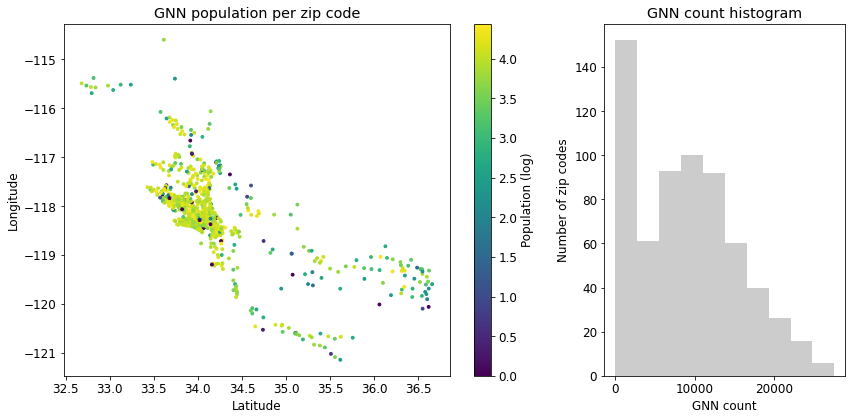

In [3]:
# EDA of dataset
fig = plt.figure(figsize=(12,6))
plt.rcParams.update({'font.size': 12})

gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
plt.subplot(gs[0])
plt.scatter(df['Median Latitude'],df['Median Longitude'], c = df['LOG_COUNT'], s=8)
cb = plt.colorbar()
cb.ax.set_ylabel('Population (log)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('GNN population per zip code')

plt.subplot(gs[1])
plt.hist(df['COUNT'], color= [.8, .8, .8])
plt.xlabel('GNN count')
plt.ylabel('Number of zip codes')
plt.title('GNN count histogram')

plt.tight_layout()
plt.show()


# Build distance matrix request and run Google Maps API 

In [5]:
# chunk destination zip codes since google's api can't handle that >100 requests per ping
def chunk_it(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out


In [8]:
# since we cannot throw the whole 640x640 request into google maps API, we break it down by origin start 
myfile = open(r'C:\Users\jacheung\Dropbox\API Keys\maps_API.txt')
API_key = myfile.read()

# build zip list for google api request 
# note that commas are replaced with %2C
df['API lat long'] = df['Median Latitude'].astype(str) + '%2C' + df['Median Longitude'].astype(str)
zip_list = "|".join(df['API lat long'].to_list())
zip_list = zip_list.split('|')

#chunking zip codes

num_destination_chunks = 8 
destination_chunks = chunk_it(zip_list,num_destination_chunks)

chunk_lengths = [len(chunks) for chunks in destination_chunks]
accumulator = 0 
distances = [0]

for k in chunk_lengths:
    accumulator += k
    distances.append(accumulator)    


# build empty matrices for distance and duration 
duration_matrix = np.zeros([len(zip_list), len(zip_list)])
distance_matrix = np.zeros([len(zip_list), len(zip_list)])

# build request components 
foundation = 'https://maps.googleapis.com/maps/api/distancematrix/json?'
units = 'units=imperial'
API = 'key=' + API_key

for origin_index, points in enumerate(zip_list):
    origins = 'origins=' + points
    print(origin_index)
    for destination_index, destination in enumerate(destination_chunks):
        destination_string = "|".join(destination)
        destination = 'destinations=' + destination_string

        # build request
        request = foundation + units + '&' + origins + '&' + destination + '&' + API

        # ping Maps API
        res = urllib.request.urlopen(request).read()
        data = json.loads(res.decode())

        # populate matrices
        for origin in data['rows']:
            duration_value = []
            distance_value = []
            for destination_loop in origin['elements']:
                duration_value.append(re.sub("[^0-9]", "", destination_loop['duration']['text']))
                distance_value.append(re.sub("[^0-9]", "", destination_loop['distance']['text']))

        duration_matrix[origin_index, distances[destination_index]:distances[destination_index+1]] = duration_value
        distance_matrix[origin_index, distances[destination_index]:distances[destination_index+1]] = distance_value

        
#save files
duration_df = pd.DataFrame(duration_matrix)
duration_df.columns = df['ZIP_CD']
duration_df.index = df['ZIP_CD']
duration_df.to_csv(working_directory + '/duration_dataframe.csv')

distance_df = pd.DataFrame(distance_matrix)
distance_df.columns = df['ZIP_CD']
distance_df.index = df['ZIP_CD']
distance_df.to_csv(working_directory + '/distance_dataframe.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Load distance/duration matrix built from Google Maps API

In [ ]:
# create pseudo distance matrix
from scipy.spatial import distance_matrix
all_coordinates = np.array(df[['Median Latitude', 'Median Longitude']])

distance_matrix = distance_matrix(all_coordinates,all_coordinates)

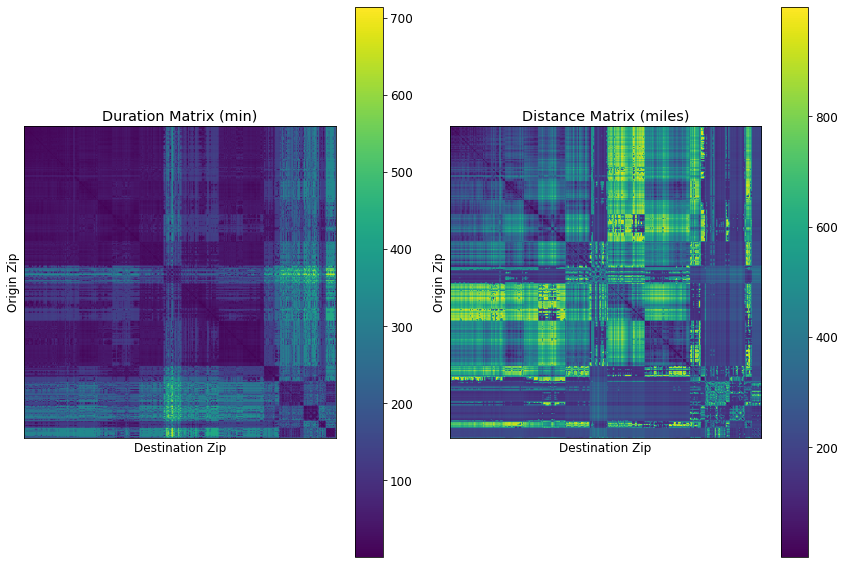

In [174]:
# load distance and duration matrices 
duration_df = pd.read_csv(working_directory + '/duration_dataframe.csv')
duration_df = duration_df.set_index('ZIP_CD').to_numpy()

distance_df = pd.read_csv(working_directory + '/distance_dataframe.csv')
distance_df = distance_df.set_index('ZIP_CD').to_numpy()

# view matrix
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(duration_df)
plt.xticks([]), plt.yticks([])
plt.ylabel('Origin Zip'), plt.xlabel('Destination Zip')
plt.title('Duration Matrix (min)')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(distance_df)
plt.xticks([]), plt.yticks([])
plt.ylabel('Origin Zip'), plt.xlabel('Destination Zip')
plt.title('Distance Matrix (miles)')
plt.colorbar()

plt.tight_layout()
plt.show()

# See ceiling of clustering via Agglomerative Clustering

Ceiling for clustering using matrix is 217.51420977652265


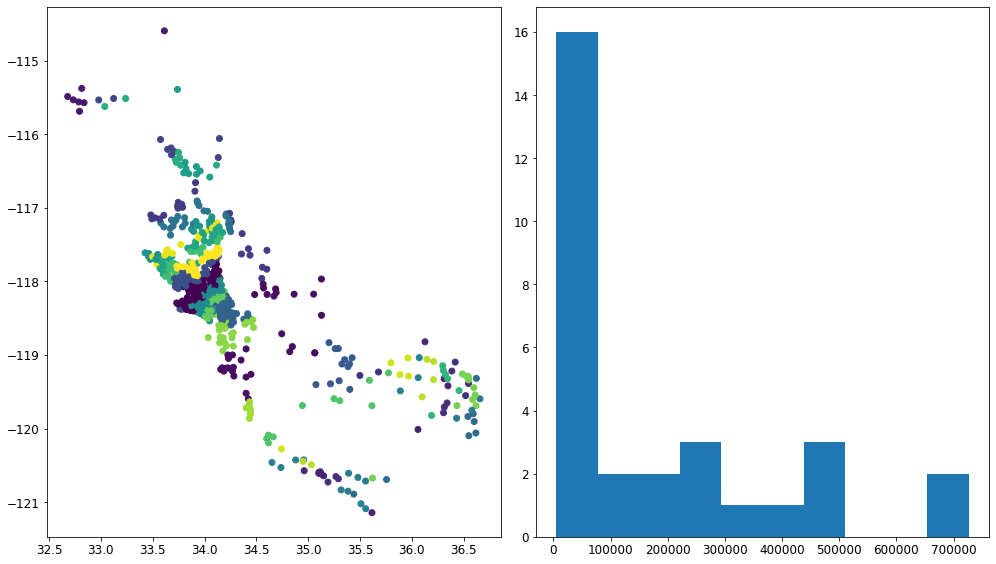

In [171]:
from sklearn.cluster import KMeans, AgglomerativeClustering
# agglomerative clustering is a type of hierachiccal clustering. It's a low-level clustering meaning that all points start
# as their own clusters. Using the matrix it then computes closest neighbors and adds to the group. 

X = df[['Median Latitude', 'Median Longitude']]

clusters = AgglomerativeClustering(n_clusters=30).fit(duration_df)
# clusters = KMeans(n_clusters=30).fit(X)
KPI_metric = metrics.calinski_harabasz_score(X, clusters.labels_)

plt.figure(figsize = (14,8))
plt.subplot(1,2,1)
plt.scatter(X['Median Latitude'], X['Median Longitude'], c = clusters.labels_)
print('Ceiling for clustering using matrix is ' + str(KPI_metric))

group = []
for k in np.unique(clusters.labels_):
    group.append(df[clusters.labels_==k]['COUNT'].sum())

plt.subplot(1,2,2)
plt.hist(group)
plt.tight_layout()
plt.show()

# Seed run and find global min

In [159]:
# params
cluster_num = 30
iterations = 10000
max_capacity = df['COUNT'].sum()/cluster_num
buffer = 500 #500 person buffer past max_capacity 
matrix_to_use = duration_df

# final outputs
KPI_solid = 0
index_solid = np.zeros([cluster_num, df.shape[0]])


for iteration in np.arange(0,iterations):
    # randomize centroid index 
    centroid_idx = np.random.choice(np.arange(0,df.shape[0]),cluster_num, replace=False)
    centroid_accumulator = np.array(df.iloc[centroid_idx,1])
    index_accumulator = np.zeros([cluster_num,df.shape[0]])
    index_accumulator[np.arange(0, cluster_num),centroid_idx] = 1
    
    # for loop that pairs a destination to closest seed using distance matrix
    points_to_pair = np.nonzero(~np.in1d(np.arange(0, df.shape[0]), centroid_idx))[0]

    for loop_idx in points_to_pair:
        sorted_distance_idx = np.argsort(matrix_to_use[loop_idx,centroid_idx])

        # accumulate population and loop_idx
        for idx in sorted_distance_idx:
            if centroid_accumulator[idx] < max_capacity + buffer:
                np.add.at(index_accumulator[idx,:],loop_idx,1)
                centroid_accumulator[idx] += df.iloc[loop_idx,1]
                break

    # KPIs for clustering: see here https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
    label,idx = np.nonzero(index_accumulator)
    labels = label[np.argsort(idx)]
    X = df[['Median Latitude', 'Median Longitude']]
#     KPI_metric = metrics.silhouette_score(X, labels, metric='euclidean')
    KPI_metric = metrics.calinski_harabasz_score(X, labels)
                             
    if KPI_metric > KPI_solid:
        print('Progress made on iteration ' + str(iteration+1))
        print('Silhouette score :' + str(KPI_metric))
        KPI_solid = KPI_metric
        index_solid = index_accumulator

Progress made on iteration 1
Silhouette score :32.85133317403713
Progress made on iteration 3
Silhouette score :33.092538482699425
Progress made on iteration 5
Silhouette score :37.24576179179386
Progress made on iteration 16
Silhouette score :46.00538050347414
Progress made on iteration 69
Silhouette score :49.356387800113474
Progress made on iteration 202
Silhouette score :52.34973958230462
Progress made on iteration 718
Silhouette score :54.630706422611006
Progress made on iteration 2528
Silhouette score :57.03439049045561
Progress made on iteration 3713
Silhouette score :58.23081354832938
Progress made on iteration 3799
Silhouette score :58.36525962554525
Progress made on iteration 5589
Silhouette score :59.22324716669356


# Simulated Annealing

# Plot clusters

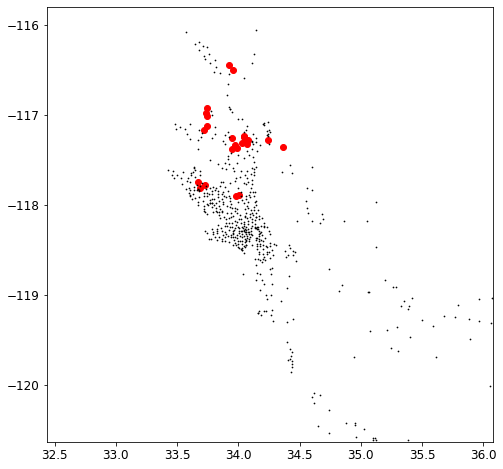

In [169]:
group_balance = []
x_mean,y_mean = df[['Median Latitude','Median Longitude']].mean()
x_sd,y_sd = df[['Median Latitude','Median Longitude']].std()

def plot_random_cluster(seed):
    fig = plt.figure(figsize=(8,8))
    plt.rcParams.update({'font.size': 12})
    points = np.nonzero(index_solid[seed,:])
    not_points = np.nonzero(index_solid[seed,:]==0)
    plot_df = df.iloc[points]
    gray_df = df.iloc[not_points]

    plt.scatter(plot_df['Median Latitude'], plot_df['Median Longitude'],c='r')
    plt.scatter(gray_df['Median Latitude'], gray_df['Median Longitude'],c='k', s = .5)
    group_balance.append(plot_df['COUNT'].sum())
    plt.xlim(x_mean-2.5*x_sd, x_mean+2.5*x_sd)
    plt.ylim(y_mean-2.5*y_sd, y_mean+2.5*y_sd)
    plt.show()
    
    
plot_random_cluster(np.random.choice(np.arange(0,index_solid.shape[0])))

In [167]:
label,idx = np.nonzero(index_solid)
labels = label[np.argsort(idx)]
df['Cluster'] = labels